In [1]:
from tpot import TPOTClassifier, TPOTRegressor
import dill
import pandas as pd

from configparser import ConfigParser
import numerapi
import os
import sys
if not os.getcwd().endswith('trading'): os.chdir('../../../../trading') # local machine
assert os.getcwd().endswith('trading'), 'Wrong path!'
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from collections import Counter
from skimpy import clean_columns

from sklearn.metrics import mean_squared_error
from pandarallel import pandarallel # parallel pandas
import platform
import time
import numpy as np
from sklearn.preprocessing import FunctionTransformer, OrdinalEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
sys.path.append(os.getcwd())

In [2]:
model_dict = dill.load(open('/media/melgazar9/HDD_10TB/trading/objects/XGBRegressor_2022-03-03_10_01_00.pkl', 'rb'))

/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### train test split

In [3]:
TARGET = 'target_20d'
PRESERVE_VARS = ['XGBRegressor_pred', 'target_4d', 'yahoo_ticker', 'date_localized', 'dataset_split']
ID_VARS = ['date']

DROP_COLS = model_dict['dropped_features'] # [i for i in model_dict['df_pred'].columns if is_datetime(model_dict['df_pred'][i]) and i not in ID_VARS + PRESERVE_VARS]
OBJECT_COLS = [i for i in model_dict['df_pred'].columns if model_dict['df_pred'][i].dtype == 'object' and i not in ID_VARS + PRESERVE_VARS]

In [5]:
try:
    model_dict['df_pred'].set_index(ID_VARS, inplace=True)
except:
    pass
try:
    model_dict['df_pred'].drop(DROP_COLS, axis=1, inplace=True)
except:
    pass

In [6]:
X_train = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train'][model_dict['input_features']]
y_train = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train'][TARGET]

X_val = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val'][model_dict['input_features']]
y_val = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val'][TARGET]

X_test = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test'][model_dict['input_features']]
y_test = model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test'][TARGET]
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((936205, 813), (936205,), (201196, 813), (201196,), (204094, 813), (204094,))

In [7]:
X_train.head()

,move_1h_8_rolling_mean,move_pct_1h_13,open_1h_11_pct_change,move_pct_change_1h_14_rolling_mean,high_move_pct_change_1h_13_ewm_mean,low_move_pct_change_1h_11,move_1h_9,move_pct_1h_10_rolling_mean,move_pct_change_1h_3,move_pct_change_1h_4_ewm_mean,...,low_move_1h_13_rolling_mean,move_pct_1h_13_ewm_mean,move_pct_change_1h_2_ewm_mean,open_1h_12_pct_change,high_move_pct_change_1h_10_ewm_mean,high_move_pct_change_1h_4,low_move_1d_iar_rolling_mean,low_move_1d_iar_ewm_mean,low_move_pct_change_1h_11_ewm_mean,range_pct_change_1h_12
date,,,,,,,,,,,,,,,,,,,,,
2015-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-805.371901,NaN,NaN
2015-02-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-935.302198,NaN,NaN
2015-02-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1478.682525,NaN,NaN
2015-03-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1859.618902,NaN,NaN
2015-03-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2186.556244,NaN,NaN


In [8]:
X_train_transformed = pd.DataFrame(model_dict['feature_transformer'].transform(X_train), columns=model_dict['final_features'])
X_val_transformed = pd.DataFrame(model_dict['feature_transformer'].transform(X_val), columns=model_dict['final_features'])
X_test_transformed = pd.DataFrame(model_dict['feature_transformer'].transform(X_test), columns=model_dict['final_features'])

/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1, 4, 6, 7, 8, 9, 10, 11, 16, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 34, 35, 36, 37, 38, 40, 41, 44, 45, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/home/melgazar9/scripts/github/trading/venv/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [1, 4, 6, 7, 8, 9, 10, 11, 16, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 32, 34, 35, 36, 37, 38, 40, 41, 44, 45, 46] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


### Original XGBRegressor score

In [9]:
print('\nTrain xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='train']['target_20d']))))

print('Train xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='val']['target_20d']))))

print('Train xgboost RMSE: {}\n'.format(
    np.sqrt(mean_squared_error(model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['XGBRegressor_pred'],
                       model_dict['df_pred'][model_dict['df_pred']['dataset_split']=='test']['target_20d']))))



Train xgboost RMSE: 0.21775636044626057

Train xgboost RMSE: 0.21478515074959081

Train xgboost RMSE: 0.210123192139244



<AxesSubplot:ylabel='Frequency'>

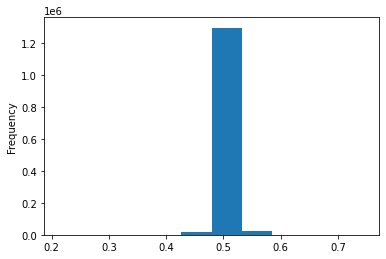

In [73]:
model_dict['df_pred']['XGBRegressor_pred'].plot(kind='hist')

In [11]:
tpot_model = TPOTRegressor(generations=5,
                           population_size=5,
                           offspring_size=None,
                           mutation_rate=0.9,
                           scoring='neg_mean_squared_error',
                           cv=3,
                           subsample=0.8,
                           n_jobs=16,
                           random_state=0,
                           use_dask=True,
                           early_stop=5).fit(X_train, y_train)

ValueError: Cannot cast object dtype to float64